# Color Classification Model 


This is a simple neural network which takes in a colored image as input and identifies the class of the image. The project will be made into an app, as of now it simply classifies basic colors. 

# Importing Packages

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
# Checking the version matches 
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np


import json

import torch 
from torch import nn, optim
from torch.autograd import Variable 
import torch.nn.functional as F
from torchvision import datasets, transforms, models 
from collections import OrderedDict 

import time 

from PIL import Image

from matplotlib import pyplot as plt 
from matplotlib import gridspec as gridspec

# Getting the data 

The data is saved in drive separated into the color folders

1.   RED
2.   GREEN
3.   BLUE
4.   WHITE
5.   YELLOW
6.   WHITE


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/My Drive/Colab Notebooks/Color Detection/Data/"

test  train


In [0]:
data_dir = "/content/drive/My Drive/Colab Notebooks/Color Detection/Data/"
train_dir = data_dir + 'train/'

# Creating the dataloaders 

With the data defined it's now time to apply the transforms and save them to data loaders

1. `RandomResizedCrop(224)` To get the images into the same shape but slightly change the data
2.  `RandomHorizontalFlip()` To add randomness to the shape of the images

In [0]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), 
                                                          (0.229, 0.224, 0.225))])

test_data = datasets.ImageFolder(data_dir + 'test/', transform=test_transforms)
training_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)


testloader = torch.utils.data.DataLoader(test_data, batch_size = 2, shuffle=False)
train_data = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True)

# Creating the model 



In [8]:
model = models.densenet121(pretrained=True)


# freezing parameters
for param in model.parameters():
    param.requires_grad = False


# Building the classifier 
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.1)),
                          ('batch_norm', nn.BatchNorm1d(500)),
                          ('fc2', nn.Linear(500,6)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

model.class_to_idx = training_dataset.class_to_idx

# Training 

In [0]:
def save_checkpoint(arch, state_dic, op_dict, lr, hidden, epochs, c_idx):
    return {
        'arch': arch,
        'state_dict': state_dic,
        'optimizer': op_dict,
        'learning_rate': lr,
        'hidden_units': hidden,
        'epochs': epochs,
        'class_to_idx': c_idx
    }

In [0]:
def eval_model(testloader, model, criterion, device, dots=False):
    running_loss = 0 
    accuracy = 0
    is_gpu = True
    
    model.eval()
    model.cuda()
    for ii, (inputs, labels) in enumerate(testloader): 
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        output = model.forward(inputs)
        running_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()  
        
    return (running_loss/len(testloader)),(accuracy/len(testloader))
  

In [12]:
from random import uniform

start = time.time()
# Training starts 

print_every = 10
previous_loss = 900
steps = 0
epochs = 40
model.train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for e in range(epochs):
    model.cuda()
    train_transforms = transforms.Compose([transforms.RandomRotation(uniform(0, 90)),
                                   transforms.RandomResizedCrop(224),
                                   transforms.RandomHorizontalFlip(uniform(0.1, 0.9)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                       [0.229, 0.224, 0.225])])


    training_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

    train_data = torch.utils.data.DataLoader(training_dataset, batch_size=8, shuffle=True)
  
    running_loss = 0
    if e > 15:
        for xx, param in enumerate(model.parameters()):
          if xx > 300:
            param.requires_grad = True
          else:
            param.requires_grad = False
    for ii, (inputs, labels) in enumerate(iter(train_data)):
        inputs, labels = inputs.to(device), labels.to(device)
        steps += 1
        optimizer.zero_grad()
        
        outputs = model.forward(inputs)
        
        # Debug info:
        # print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            eval_loss, eval_accuracy = eval_model(testloader, model, criterion, device, True)
            print("Epoch: {}/{}".format(e+1, epochs), "Loss: {:.3f}".format(running_loss / print_every))
            print("Validation Loss {:.3f} Accuracy {:.4f}".format(eval_loss, eval_accuracy))
            if eval_loss < previous_loss:
              file = 'new_densenet.pth'
              checkpoint = save_checkpoint('densenet121', model.state_dict(), optimizer.state_dict(), 0.001, 1104, 
                             e, model.class_to_idx)
              torch.save(checkpoint, file)
            running_loss = 0
            model.train()
end = time.time()
print("Training completed in {} seconds!".format(round(end - start)))

Epoch: 2/40 Loss: 0.649
Validation Loss 1.080 Accuracy 0.8000
Epoch: 4/40 Loss: 0.371
Validation Loss 0.751 Accuracy 0.8000
Epoch: 6/40 Loss: 0.275
Validation Loss 0.494 Accuracy 1.0000
Epoch: 8/40 Loss: 0.381
Validation Loss 0.439 Accuracy 0.9000
Epoch: 10/40 Loss: 0.192
Validation Loss 0.507 Accuracy 0.9000
Epoch: 12/40 Loss: 0.420
Validation Loss 0.336 Accuracy 0.9000
Epoch: 14/40 Loss: 0.309
Validation Loss 0.341 Accuracy 0.9000
Epoch: 16/40 Loss: 0.172
Validation Loss 0.336 Accuracy 0.9000
Epoch: 18/40 Loss: 0.261
Validation Loss 0.366 Accuracy 0.8000
Epoch: 20/40 Loss: 0.198
Validation Loss 0.355 Accuracy 0.9000
Epoch: 22/40 Loss: 0.272
Validation Loss 0.687 Accuracy 0.9000
Epoch: 24/40 Loss: 0.341
Validation Loss 0.509 Accuracy 0.9000
Epoch: 26/40 Loss: 0.160
Validation Loss 0.242 Accuracy 1.0000
Epoch: 28/40 Loss: 0.146
Validation Loss 0.309 Accuracy 0.9000
Epoch: 30/40 Loss: 0.219
Validation Loss 0.516 Accuracy 0.9000
Epoch: 32/40 Loss: 0.374
Validation Loss 0.266 Accuracy 0.9

In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        model = model.cpu()
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 8 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 8 test images: 88 %


# Predicting the output 

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Resizing the image 
    width, height = image.size
    tgt_size = 256
    
    
    height = [int(tgt_size) if height > width else int(max(height * tgt_size/width, 1))][0]
    width = [int(tgt_size) if height < width else int(max(height * tgt_size/width, 1))][0]

    print(width, height)
    resized_img = image.resize((width, height)) 
    
    # Cropping the image 
    tgt_size2 = 224
    width2, height2 = resized_img.size 
    x1 = (width2 - tgt_size2) / 2
    x2 = (height2 - tgt_size2) / 2
    x3 = x1 + tgt_size2
    x4 = x2 + tgt_size2
    
    crop_img = resized_img.crop((x1, x2, x3, x4))
    
    np_image = np.array(crop_img)/255. 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])     
    np_image = (np_image - mean) / std
    
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose(1, 2, 0)
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

346 256


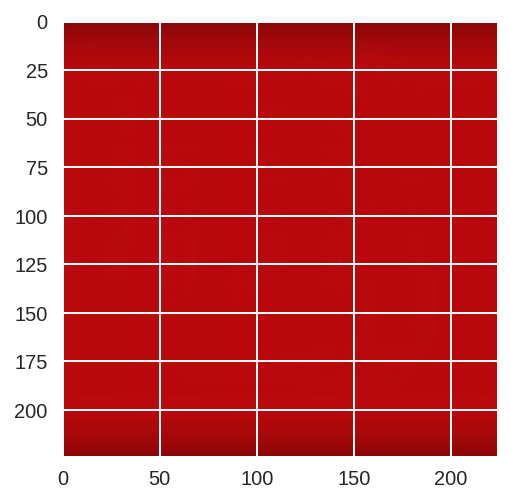

In [16]:
img_path = data_dir + 'test/RED/red2.jpg' 
img = Image.open(img_path)
np_arr = process_image(img)
tensor = torch.from_numpy(np_arr)
imshow(tensor)

In [0]:
def predict(image_path, model, topk=4,device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    model.cuda()
      
    img = Image.open(image_path)
    image = process_image(img)       
   
    myInput = torch.FloatTensor(image).cuda()  # Avoids sizes do not match error 
    myInput.unsqueeze_(0)
    output = model(myInput)
    
    ps = F.softmax(output, dim = 1)
    probs, classes = torch.topk(ps, topk)
    
    inverted_class_2_index = {model.class_to_idx[x]: x for x in model.class_to_idx}
    new_classes = []
    
    for index in classes.cpu().numpy()[0]:
        new_classes.append(inverted_class_2_index[index])
        
    return probs.cpu().detach().numpy()[0], new_classes

In [18]:
img_path = data_dir + 'test/YELLOW/yellow6.jpeg' 
probs, classes = predict(img_path, model)

# # Debug info 
print(probs)
print(classes)

256 159
[0.6329529  0.25181228 0.07194384 0.02147834]
['YELLOW', 'BLUE', 'BLACK', 'WHITE']


256 159
[0 1 2 3] [0.6329529  0.25181228 0.07194384 0.02147834]


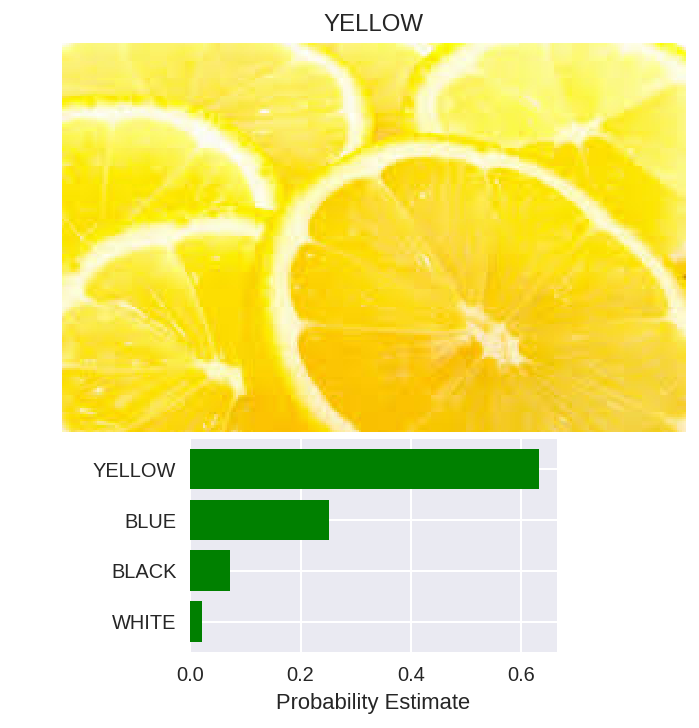

In [19]:
my_images = img_path

probs, classes = predict(img_path, model)

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)


with torch.no_grad():
    image = Image.open(img_path)    
    max_index = np.argmax(probs)
    max_prob = probs[max_index]
    max_classes = classes[max_index]

    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title(max_classes)
 
    y_label = (index for index in classes)
    y_position = np.arange(4)
    ax2.set_yticks(y_position)
    ax2.set_yticklabels(y_label)
    ax2.invert_yaxis()
    ax2.set_xlabel('Probability Estimate')
    print(y_position, probs)
    ax2.barh(y_position, probs, align = 'center', color = 'green')
    
    plt.show()

329 256
[0 1 2 3] [9.8729169e-01 1.1935456e-02 6.9670711e-04 5.8371264e-05]


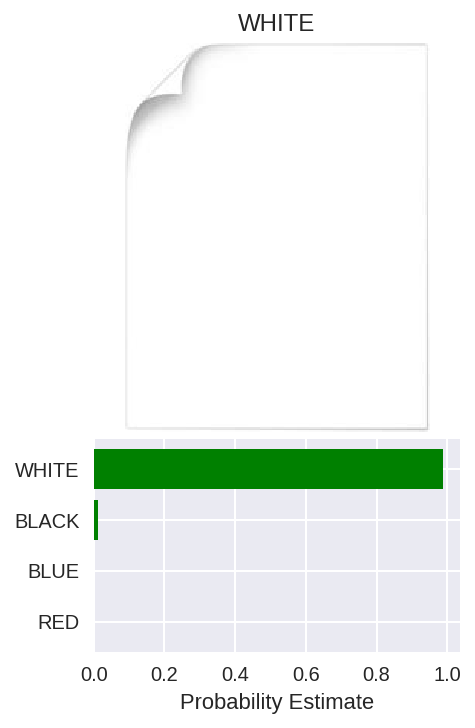

In [20]:
img_path = data_dir + 'test/WHITE/white5.jpeg' 
my_images = data_dir + 'test/WHITE/white5.jpeg' 

probs, classes = predict(img_path, model)

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)


with torch.no_grad():
    image = Image.open(img_path)    
    max_index = np.argmax(probs)
    max_prob = probs[max_index]
    max_classes = classes[max_index]

    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title(max_classes)
 
    y_label = (index for index in classes)
    y_position = np.arange(4)
    ax2.set_yticks(y_position)
    ax2.set_yticklabels(y_label)
    ax2.invert_yaxis()
    ax2.set_xlabel('Probability Estimate')
    print(y_position, probs)
    ax2.barh(y_position, probs, align = 'center', color = 'green')
    
    plt.show()

# Uploading the checkpoint 

The following code will save the checkpoint to drive 

In [22]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'new_densenet': 'new_densenet.pth'})
uploaded.SetContentFile('new_densenet.pth')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1_DzYBF44uCYELKSkA_U3wMmUdnzGwta-
